In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision.utils import make_grid
from sklearn.metrics import pairwise_distances

root_dir = "../.."
sys.path.append(root_dir)
from configs import get_config
from classifiers import get_classifier
from datasets import get_dataset
from notebooks.utils import viz_explanation

config_name = "chexpert_claim"
config_dict = {
    "data.dataset": "chexpert",
    "data.explanation_length": 8,
    "listener.type": "claim",
    "listener.gamma": 0.4,
    "speaker.alpha": [0.0, 0.2],  # do not change this
}
config = get_config(config_name, config_dict=config_dict)

classifier = get_classifier(config, device="cpu")
preprocess = classifier.preprocess

dataset = get_dataset(config, train=False, transform=preprocess, return_attribute=True)
classes = dataset.classes

lit_results, prag_results = [c.get_results() for c in config.sweep(["speaker.alpha"])]
for r in [lit_results, prag_results]:
    r["listener_prediction"] = r["action"].apply(lambda x: np.argmax(x))
    r["correct"] = r["listener_prediction"] == r["prediction"]

idx = (
    (lit_results["label"] == lit_results["prediction"])
    * (lit_results["correct"] == False)
    * prag_results["correct"]
)
idx = np.nonzero(idx.values)[0]

sns.set_theme()
sns.set_context("paper")

/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of mode

In [2]:
# add grid
sns.set_style()
categories = [
                'Enlarged Cardiomediastinum',
                'Cardiomegaly',
                'Lung Lesion',
                'Edema',
                'Consolidation',
                'Pneumonia',
                'Atelectasis',
                'Pneumothorax',
                'Pleural Effusion',
                'Pleural Other',
                'Fracture',
                'Support Devices'
            ]
target_categories = [
    'Edema',
    'Consolidation',
    'Pneumonia',
     'Atelectasis',
     'Lung Lesion']

def show_explanation_summary(dataset, lit_results, prag_results, label, classifer_prediction):
 
    idx = (
    (lit_results["label"] == label)
    * (lit_results["prediction"] == classifer_prediction)
    *(lit_results["listener_prediction"] == classifer_prediction)
    * (prag_results["listener_prediction"] == classifer_prediction)
    )
    idx = np.nonzero(idx.values)[0]
    Attr_count_lit = np.zeros((12, 4))
    Attr_count_prag = np.zeros((12, 4))
    Attr_count_gd = np.zeros((12))
    for index, row in lit_results.iterrows():
        if index not in idx:
            continue
        image, label, image_attribute = dataset[index]
        Attr_count_gd += image_attribute
        explanation = row["explanation"]
        for attr_i, attr_v in explanation:
            if attr_i < 12:
                if attr_v == 1 and image_attribute[attr_i] == 1:
                    Attr_count_lit[attr_i][0] += 1
                elif attr_v == 0 and image_attribute[attr_i] == 0:
                    Attr_count_lit[attr_i][1] += 1
                elif attr_v == 1 and image_attribute[attr_i] == 0:
                    Attr_count_lit[attr_i][2] += 1
                elif attr_v == 0 and image_attribute[attr_i] == 1:
                    Attr_count_lit[attr_i][3] += 1
    for index, row in prag_results.iterrows():
        if index not in idx:
            continue
        image, label, image_attribute = dataset[index]
        explanation = row["explanation"]
        for attr_i, attr_v in explanation:
            if attr_i < 12:
                if attr_v == 1 and image_attribute[attr_i] == 1:
                    Attr_count_prag[attr_i][0] += 1
                elif attr_v == 0 and image_attribute[attr_i] == 0:
                    Attr_count_prag[attr_i][1] += 1
                elif attr_v == 1 and image_attribute[attr_i] == 0:
                    Attr_count_prag[attr_i][2] += 1
                elif attr_v == 0 and image_attribute[attr_i] == 1:
                    Attr_count_prag[attr_i][3] += 1
    tp_lit = Attr_count_lit[:,0]/len(idx)
    tn_lit = Attr_count_lit[:,1]/len(idx)
    fp_lit = Attr_count_lit[:,2]/len(idx)
    fn_lit = Attr_count_lit[:,3]/len(idx)
    not_mentioned_lit = 1- tp_lit - tn_lit - fp_lit - fn_lit
    
    
    tp_prag = Attr_count_prag[:,0]/len(idx)
    tn_prag = Attr_count_prag[:,1]/len(idx)
    fp_prag = Attr_count_prag[:,2]/len(idx)
    fn_prag = Attr_count_prag[:,3]/len(idx)
    not_mentioned_prag = 1- tp_prag - tn_prag - fp_prag - fn_prag
    
    # print(Attr_count)
    Attr_count_gd_p = Attr_count_gd/len(idx)
    Attr_count_gd_n = 1- Attr_count_gd/len(idx)
    
    x = np.arange(len(categories))  # label locations
    width = 0.35  # width of the bars
    fig, (ax_lit, ax_prag, ax1) = plt.subplots(3, 1, figsize=(10, 3), sharex=True)    
    bar_tp = ax_lit.bar(x - width/2, tp_lit, width, label='TP', color=sns.color_palette("Paired")[0])
    bar_fp = ax_lit.bar(x - width/2, fp_lit, width, bottom=tp_lit, label='FP', color=sns.color_palette("Paired")[1])
    bar_tn = ax_lit.bar(x - width/2, tn_lit, width, bottom=tp_lit+fp_lit,label='TN', color=sns.color_palette("Paired")[4])
    bar_fn = ax_lit.bar(x - width/2, fn_lit, width, bottom=tp_lit+fp_lit+tn_lit, label='FN', color=sns.color_palette("Paired")[5])
    bar_not_mentioned = ax_lit.bar(x - width/2, not_mentioned_lit, width, bottom=tp_lit+fp_lit+tn_lit+fn_lit, label='Not Mentioned', color='grey', alpha=0.5)
    
    bar_tp = ax_prag.bar(x - width/2, tp_prag, width, label='TP', color=sns.color_palette("Paired")[0])
    bar_fp = ax_prag.bar(x - width/2, fp_prag, width, bottom=tp_prag, label='FP', color=sns.color_palette("Paired")[1])
    bar_tn = ax_prag.bar(x - width/2, tn_prag, width, bottom=tp_prag + fp_prag,label='TN', color=sns.color_palette("Paired")[4])
    bar_fn = ax_prag.bar(x - width/2, fn_prag, width, bottom=tp_prag + fp_prag +tn_prag , label='FN', color=sns.color_palette("Paired")[5])
    bar_not_mentioned = ax_prag.bar(x - width/2, not_mentioned_prag, width, bottom=tp_prag + fp_prag +tn_prag + fn_prag, label='Not Mentioned', color='grey', alpha=0.5)

  
    ax1.bar(x - width/2, Attr_count_gd_p, width, label='Positive', color=sns.color_palette("Paired")[0])
    ax1.bar(x - width/2, Attr_count_gd_n, width, label='Negative',bottom = Attr_count_gd_p,  color=sns.color_palette("Paired")[4], )

    ax_lit.legend(title = "Speaker's explanation", loc='upper left', bbox_to_anchor=(1, 1))
    ax1.legend(title = 'Ground truth', loc='upper left', bbox_to_anchor=(1, 1))
    # ax.set_ylim(0, 0.5)
    if label == 1:
        label_text = "Lung Opacity"
    elif label == 0:
        label_text = "No Lung Opacity"
    if classifer_prediction == 1:
        classifer_prediction = "Lung Opacity"
    elif classifer_prediction == 0:
        classifer_prediction = "No Lung Opacity"
    ax_lit.set_title(f"Prevalence of attribute [Ground truth: {label_text}, Classifier: {classifer_prediction}, Listener: {classifer_prediction}]")
    
    ax_lit.set_ylabel("Literal")
    ax_prag.set_ylabel("Pragmatic")
    ax_lit.set(ylim = (0, 1))
    ax_prag.set(ylim = (0, 1))
    ax1.set(ylim = (0, 1))
    ax1.set_ylabel("Annotations")
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha="right")
    # highlight the target categories with bold font
    for i, l in enumerate(ax1.xaxis.get_majorticklabels()):
        if l.get_text() in target_categories:
            l.set_fontweight("bold")
        else:
            l.set_fontweight("normal")

    plt.tight_layout()
    plt.show()
    
    if label == 1:
        
        Map = np.stack((tp_lit, tp_prag, Attr_count_gd_p), axis=1)
        Map = Map.T
        fig, ax = plt.subplots(figsize=(10, 3))
        sns.heatmap(Map, annot=True, fmt=".2f", cmap="Blues", cbar=False, linewidths=0.5, linecolor='white', ax=ax)
        ax.set_yticklabels(['Literal', 'Pragmatic', 'Ground Truth'], rotation=0)
        ax.set_xticklabels(categories, rotation=30)
        # highlight the target categories with bold font
        for i, l in enumerate(ax.xaxis.get_majorticklabels()):
            if l.get_text() in target_categories:
                l.set_fontweight("bold")
            else:
                l.set_fontweight("normal")
  
        plt.tight_layout()
        fig.show()
    if label == 0:
        Map = np.stack((tn_lit, tn_prag, Attr_count_gd_n), axis=1)
        Map = Map.T
        fig, ax = plt.subplots(figsize=(10, 3))
        sns.heatmap(Map, annot=True, fmt=".2f", cmap="Reds", cbar=False, linewidths=0.5, linecolor='white', ax=ax)
        ax.set_yticklabels(['Literal', 'Pragmatic', 'Ground Truth'], rotation=0)
        ax.set_xticklabels(categories, rotation=30)
        # highlight the target categories with bold font
        for i, l in enumerate(ax.xaxis.get_majorticklabels()):
            if l.get_text() in target_categories:
                l.set_fontweight("bold")
            else:
                l.set_fontweight("normal")
   
      
        plt.tight_layout()
        fig.show()
    
# show_explanation_summary(dataset, lit_results, prag_results, 1, 1)
# show_explanation_summary(lit_results, 0, 0)
# show_explanation_summary(dataset, prag_results, 1,1, 1)
# show_explanation_summary(prag_results, 0, 0)

/tmp/ipykernel_2467662/1310331689.py:132: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


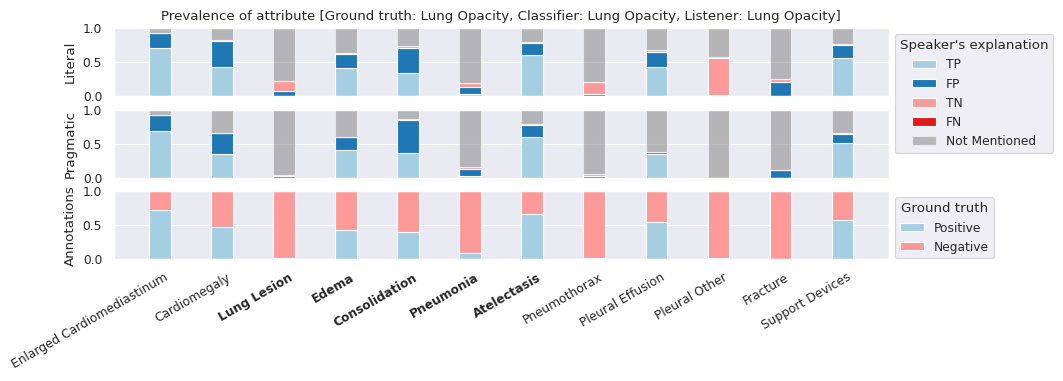

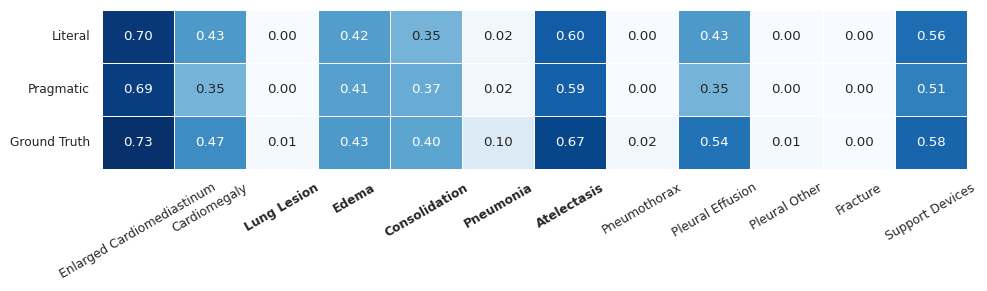

In [3]:
show_explanation_summary(dataset, lit_results, prag_results, 1, 1)

/tmp/ipykernel_2467662/1310331689.py:132: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


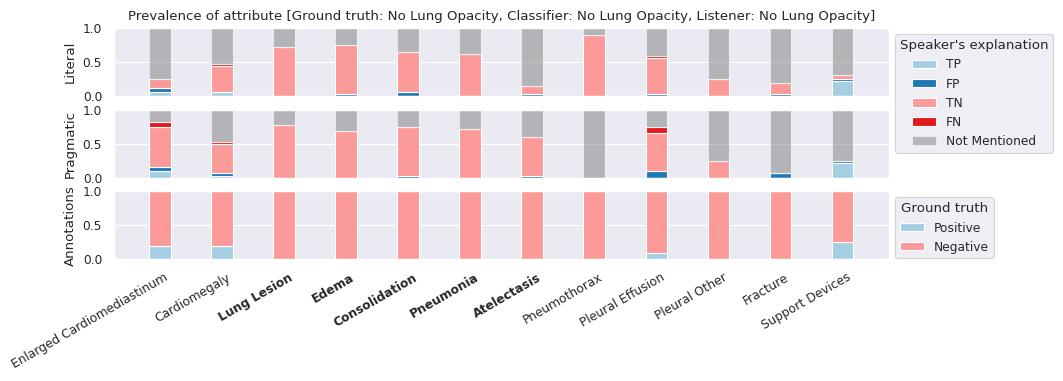

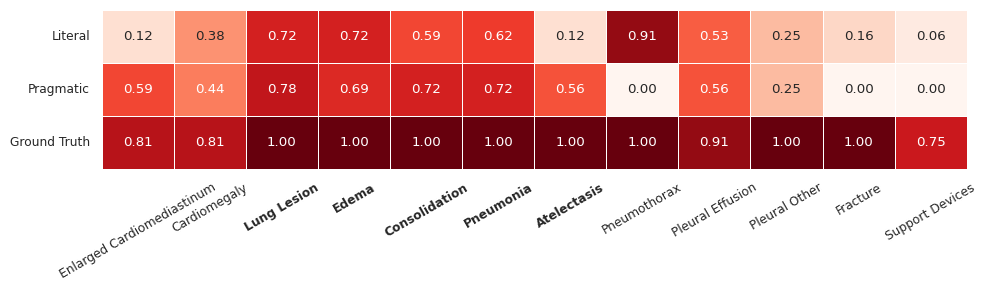

In [4]:
show_explanation_summary(dataset, lit_results,prag_results, 0, 0)
# show_explanation_summary(lit_results, 0, 0)
# show_explanation_summary(dataset, prag_results, 0,0, 0)
# show_explanation_summary(prag_results, 0, 0)